In [ ]:
!kaggle datasets download -d fedesoriano/hepatitis-c-dataset

# Unzip the file
!unzip hepatitis-c-dataset.zip

^C
Dataset URL: https://www.kaggle.com/datasets/fedesoriano/hepatitis-c-dataset
License(s): ODbL-1.0
hepatitis-c-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
^C


## Problem Statment:
### Detect Hepatitis C cases using patient and lab data.

#### Import necessary libraries

In [56]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from xgboost import XGBClassifier

import joblib

#### Data Collection

In [14]:
df = pd.read_csv('HepatitisCdata.csv')

In [15]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [16]:
df.head(3)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    object 
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    object 
 3   ALB       614 non-null    float64
 4   ALP       597 non-null    float64
 5   ALT       614 non-null    float64
 6   AST       615 non-null    float64
 7   BIL       615 non-null    float64
 8   CHE       615 non-null    float64
 9   CHOL      605 non-null    float64
 10  CREA      615 non-null    float64
 11  GGT       615 non-null    float64
 12  PROT      614 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 62.6+ KB


### Data Cleaning and Initial Exploration

<Axes: >

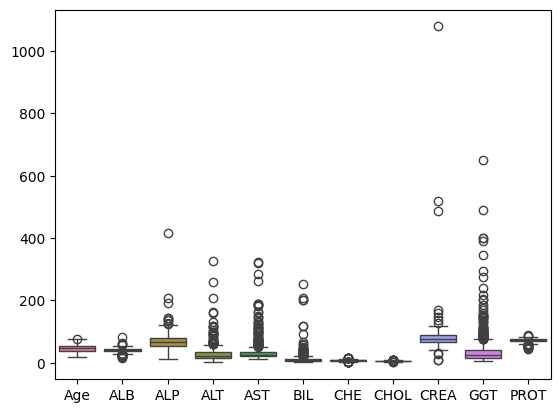

In [18]:
sns.boxplot(data=df)

In [19]:
df.skew(numeric_only=True).sort_values()


PROT    -0.963687
ALB     -0.176768
CHE     -0.110233
Age      0.267134
CHOL     0.375828
ALP      4.654921
AST      4.940327
ALT      5.506114
GGT      5.632734
BIL      8.385437
CREA    15.169291
dtype: float64

In [20]:
df.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

In [21]:
# df['ALB'] = df['ALB'].fillna(df['ALB'].mean())
# df['ALP'] = df['ALP'].fillna(df['ALP'].median())
# df['ALT'] = df['ALT'].fillna(df['ALT'].median())
# df['CHOL'] = df['CHOL'].fillna(df['CHOL'].mean())
# df['PROT'] = df['PROT'].fillna(df['PROT'].median())

In [22]:
df.isnull().sum()

Category     0
Age          0
Sex          0
ALB          1
ALP         18
ALT          1
AST          0
BIL          0
CHE          0
CHOL        10
CREA         0
GGT          0
PROT         1
dtype: int64

## EDA

In [23]:
df.shape

(615, 13)

In [24]:
df.describe()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,615.000000,614.000000,597.000000,614.000000,615.000000,615.000000,615.000000,605.000000,615.000000,615.000000,614.000000
mean,47.408130,41.620195,68.283920,28.450814,34.786341,11.396748,8.196634,5.368099,81.287805,39.533171,72.044137
std,10.055105,5.780629,26.028315,25.469689,33.090690,19.673150,2.205657,1.132728,49.756166,54.661071,5.402636
min,19.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,39.000000,38.800000,52.500000,16.400000,21.600000,5.300000,6.935000,4.610000,67.000000,15.700000,69.300000
50%,47.000000,41.950000,66.200000,23.000000,25.900000,7.300000,8.260000,5.300000,77.000000,23.300000,72.200000
75%,54.000000,45.200000,80.100000,33.075000,32.900000,11.200000,9.590000,6.060000,88.000000,40.200000,75.400000
max,77.000000,82.200000,416.600000,325.300000,324.000000,254.000000,16.410000,9.670000,1079.100000,650.900000,90.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615 entries, 0 to 614
Data columns (total 13 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Category  615 non-null    object 
 1   Age       615 non-null    int64  
 2   Sex       615 non-null    object 
 3   ALB       614 non-null    float64
 4   ALP       597 non-null    float64
 5   ALT       614 non-null    float64
 6   AST       615 non-null    float64
 7   BIL       615 non-null    float64
 8   CHE       615 non-null    float64
 9   CHOL      605 non-null    float64
 10  CREA      615 non-null    float64
 11  GGT       615 non-null    float64
 12  PROT      614 non-null    float64
dtypes: float64(10), int64(1), object(2)
memory usage: 62.6+ KB


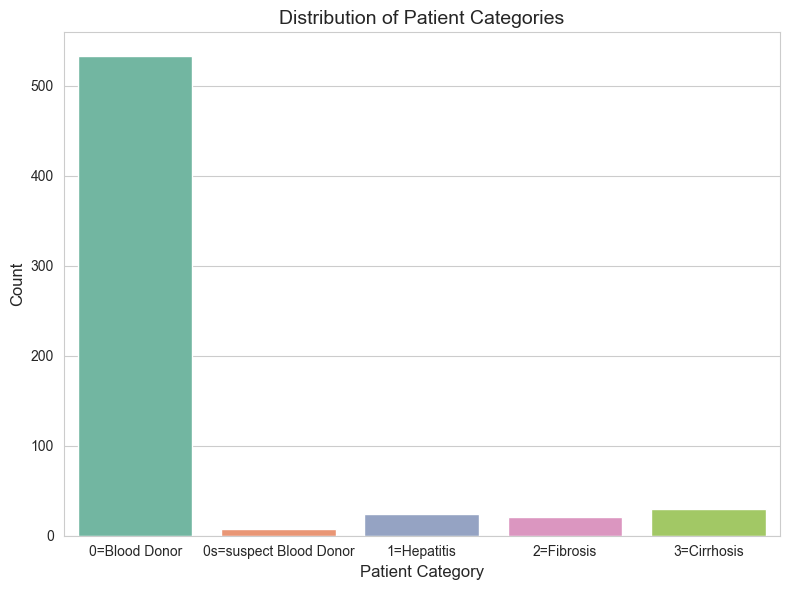

In [26]:
plt.figure(figsize=(8, 6))
sns.set_style("whitegrid")

ax = sns.countplot(data=df, x='Category', palette='Set2',hue='Category',legend=False)

plt.xlabel("Patient Category", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Patient Categories", fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

plt.tight_layout()
plt.show()

In [27]:
# Creating target column for Binary Classification and Keeping Category column to try ,Multiclass classification
df['target'] = df['Category'].replace({'0=Blood Donor': 0, '0s=suspect Blood Donor': 0, '1=Hepatitis': 1, '2=Fibrosis': 1, '3=Cirrhosis': 1}).astype(int)

C:\Users\Ali Yasoob\AppData\Local\Temp\ipykernel_26440\1294149304.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['target'] = df['Category'].replace({'0=Blood Donor': 0, '0s=suspect Blood Donor': 0, '1=Hepatitis': 1, '2=Fibrosis': 1, '3=Cirrhosis': 1}).astype(int)


In [28]:
df['target'].value_counts()

target
0    540
1     75
Name: count, dtype: int64

### Our Target Variable is Highly Skewed
- -> Accuracy will be misleading 
- -> need to do stratified train test split
- -> Ensemble models might work better

(array([  0., 100., 200., 300., 400., 500., 600.]),
 [Text(0, 0.0, '0'),
  Text(0, 100.0, '100'),
  Text(0, 200.0, '200'),
  Text(0, 300.0, '300'),
  Text(0, 400.0, '400'),
  Text(0, 500.0, '500'),
  Text(0, 600.0, '600')])

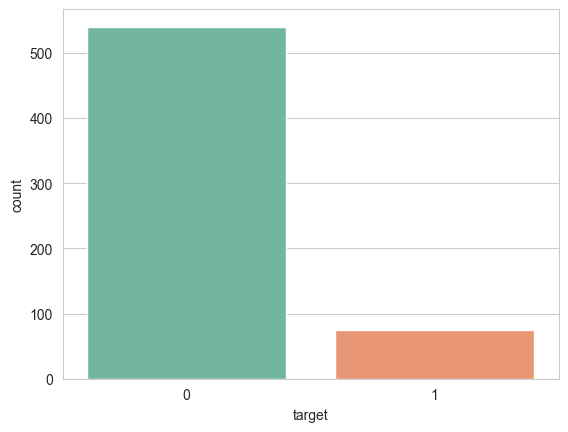

In [29]:
sns.countplot(data=df, x='target', palette='Set2',hue='target',legend=False)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

## Visualizations

Age is Close to normally distributed

np.float64(0.2671344915803825)

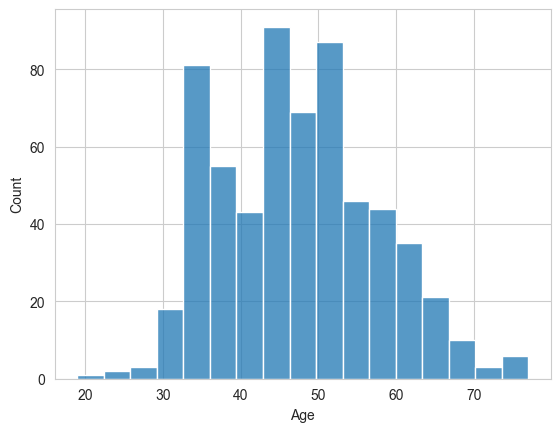

In [30]:
sns.histplot(data=df, x='Age')
df['Age'].skew()   

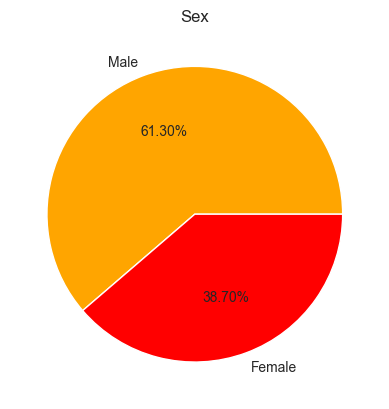

In [31]:
plt.pie(df['Sex'].value_counts(),labels=['Male','Female'],autopct='%1.2f%%',colors=['orange','red'])
plt.title("Sex")
plt.show()

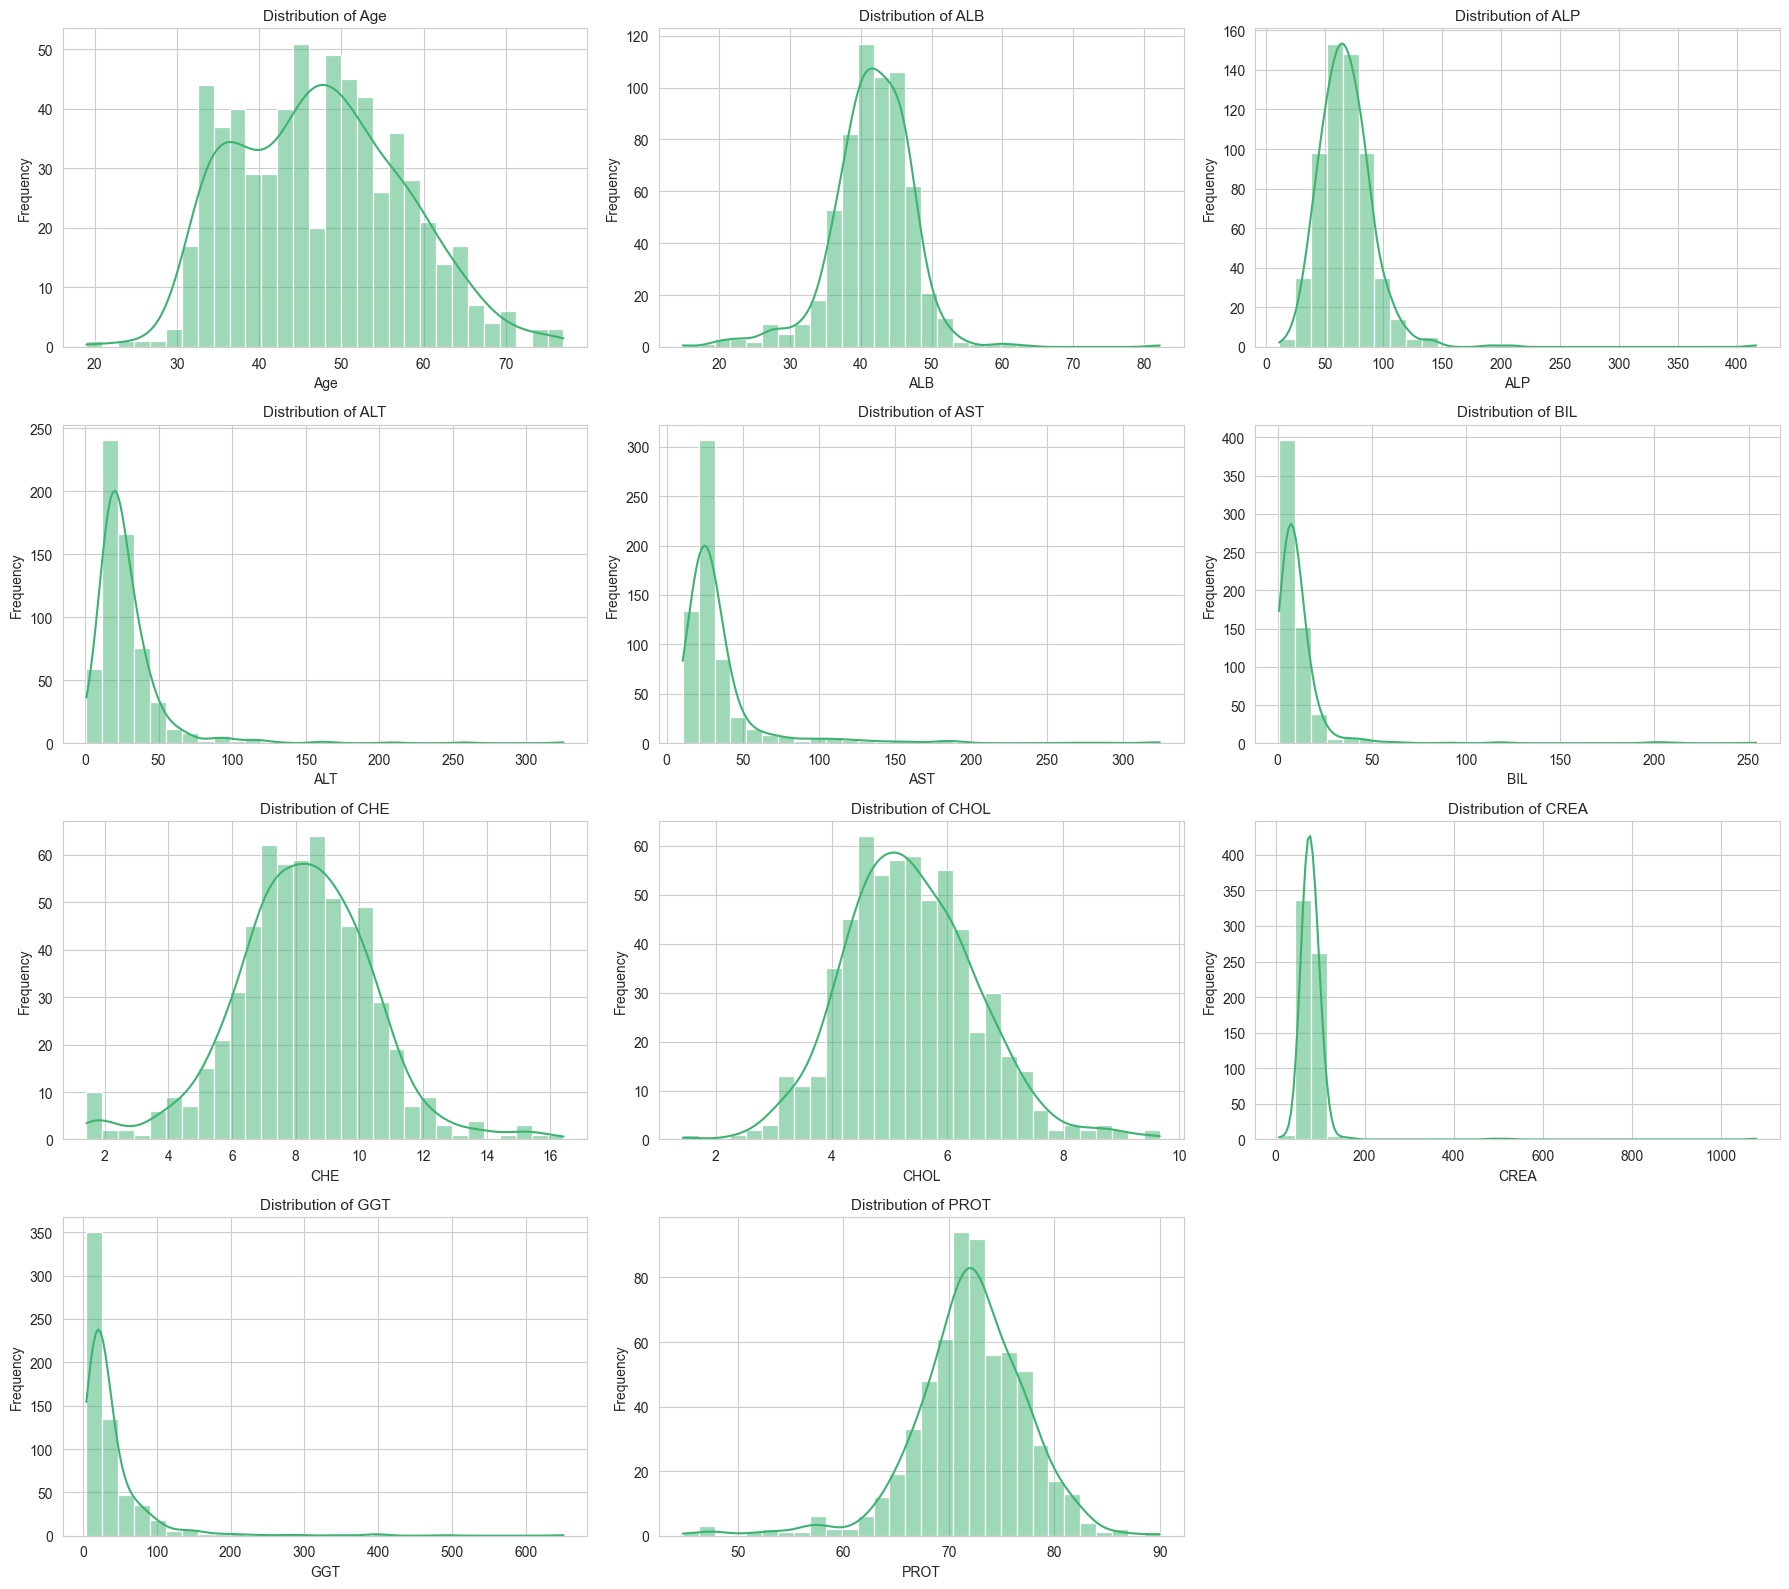

In [32]:
numerical_cols = ['Age', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT']

n_cols = 3  
n_rows = 4  
plt.figure(figsize=(18,16))  
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30, color='mediumseagreen')
    plt.title(f'Distribution of {col}', fontsize=11)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


ALP, ALT, AST, BIL, CREA, GGT are Right Skewed

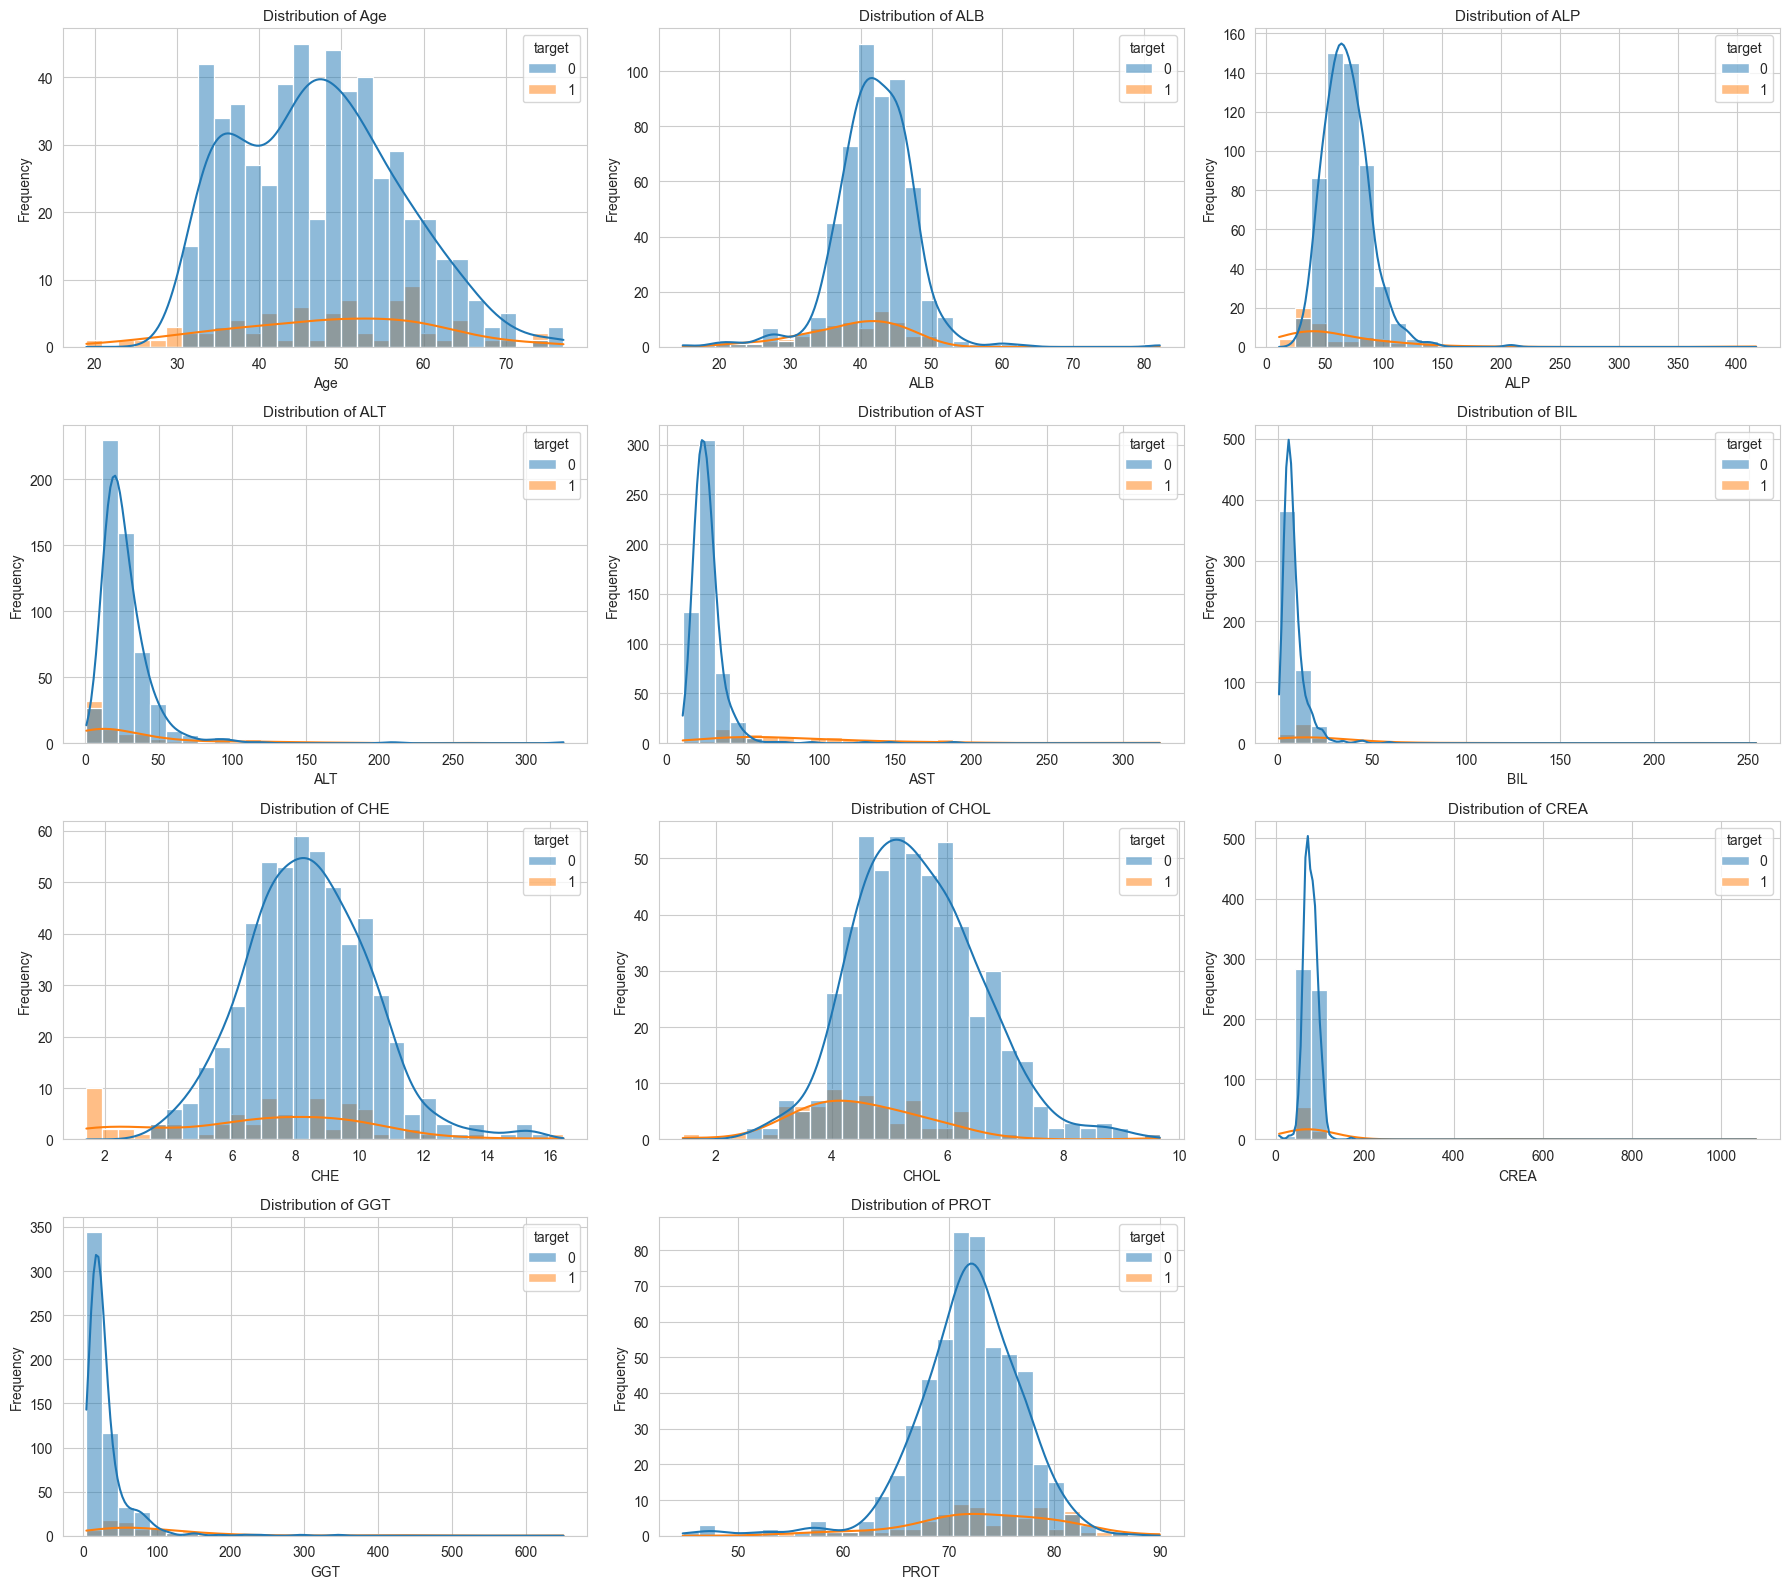

In [33]:
plt.figure(figsize=(18,16))  
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(data=df,x=col, kde=True,hue=df['target'], bins=30, color='mediumseagreen')
    plt.title(f'Distribution of {col}', fontsize=11)
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


<Axes: >

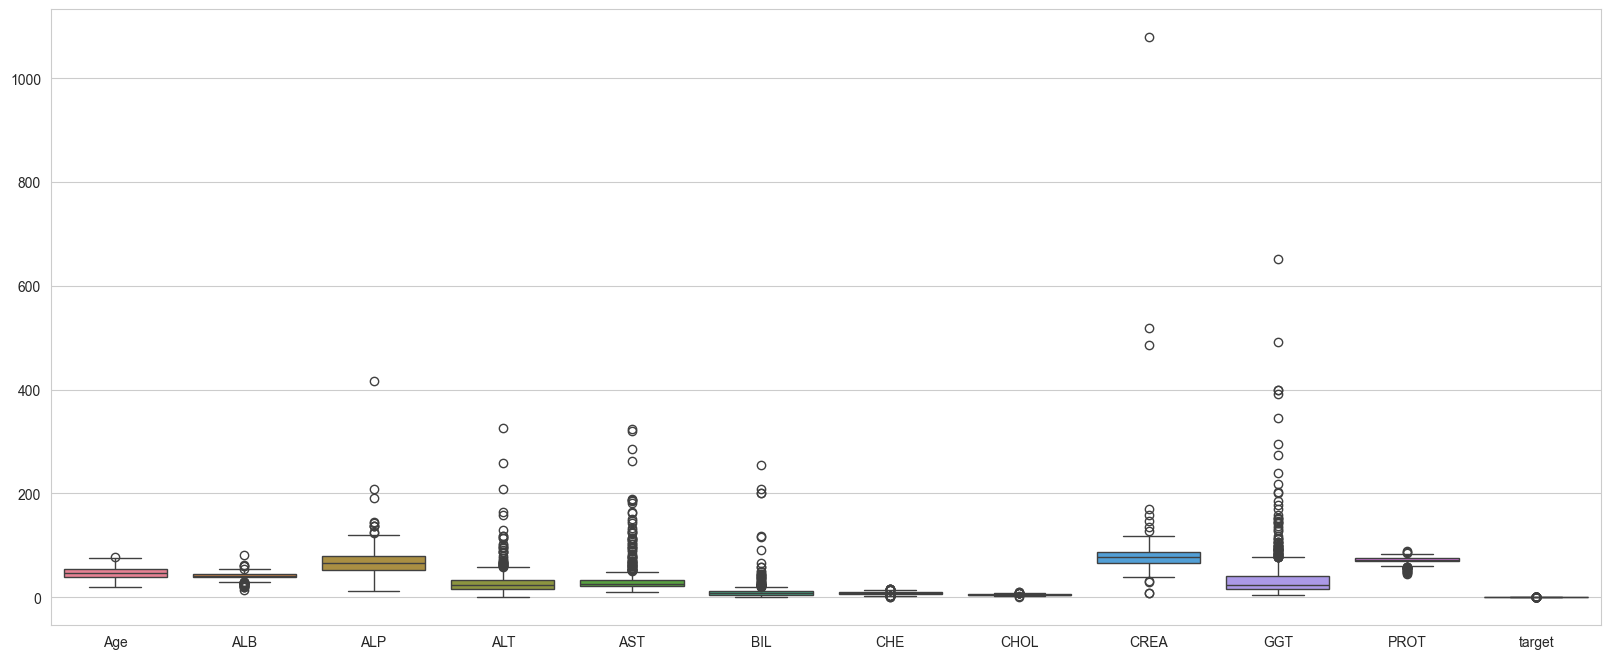

In [34]:
plt.figure(figsize=(20,8))
sns.boxplot(df)

In [35]:
df.corr(numeric_only=True)['target'].sort_values(ascending=False)

target    1.000000
AST       0.621724
GGT       0.437680
BIL       0.398451
CREA      0.136772
ALT       0.089251
PROT      0.084453
Age       0.037781
ALP      -0.069342
ALB      -0.180923
CHE      -0.230785
CHOL     -0.270496
Name: target, dtype: float64

<Axes: >

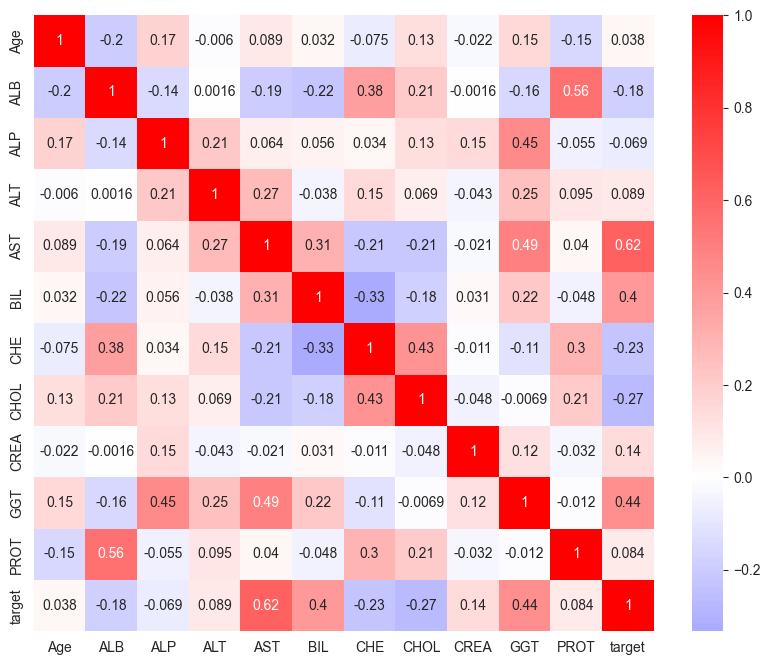

In [36]:
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(numeric_only=True),cmap='bwr',center=0,annot=True)

Observations - Some features are Correlated 

In [37]:
df.head()

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,target
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0,0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5,0
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3,0
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7,0
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7,0


### Split dataset into Training and Testing dataset

In [38]:
X = df.drop(columns=['Category','target'])
y = df['target']

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=4)

In [41]:
X_train.shape, X_test.shape

((461, 12), (154, 12))

## Building Pipelines and Transformers

In [42]:
# Categorical
cat_cols = ['Sex']

# Some Cols are right skewed, Log Transformer could handle this
log_cols = ['ALP', 'ALT', 'AST', 'BIL', 'CREA', 'GGT']

# Other numerical features
num_cols = ['ALB', 'CHE', 'CHOL', 'PROT', 'Age']

In [45]:
log_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='median')),
    ('log1p',FunctionTransformer(np.log1p,validate=True)),
    ('scaler',StandardScaler())
])

num_transformer = Pipeline([
    ('imputer',SimpleImputer(strategy='mean')),
    ('scaler',StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ('log', log_transformer, log_cols),
    ('num', num_transformer, num_cols),
    ('cat', cat_transformer, cat_cols)
])

In [62]:
pipeline_xgb = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', XGBClassifier(scale_pos_weight=df['target'].value_counts()[0] / df['target'].value_counts()[1], random_state=42))
])


In [72]:
pipeline_xgb.fit(X_train,y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluating the model

In [ ]:


y_pred = pipeline_xgb.predict(X_test)
y_proba = pipeline_xgb.predict_proba(X_test)[:, 1]


print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       135
           1       0.90      0.95      0.92        19

    accuracy                           0.98       154
   macro avg       0.95      0.97      0.96       154
weighted avg       0.98      0.98      0.98       154

ROC AUC Score: 0.9949317738791423


In [ ]:

scores = cross_val_score(pipeline_xgb, X, y, cv=5, scoring='accuracy')
print("Cross-validated accuracy scores:", scores)
print("Mean Accuracy:", scores.mean())


Cross-validated accuracy scores: [0.92682927 0.97560976 0.96747967 0.98373984 0.95934959]
Mean Accuracy: 0.9626016260162602


### Creating A PipeLine with Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

pipeline_logReg = Pipeline([
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression())
])

pipeline_logReg.fit(X_train, y_train)

,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('log', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [66]:
pipeline_logReg.fit(X_train, y_train)

y_pred = pipeline_logReg.predict(X_test)
y_proba = pipeline_logReg.predict_proba(X_test)[:, 1]

from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       135
           1       0.94      0.89      0.92        19

    accuracy                           0.98       154
   macro avg       0.96      0.94      0.95       154
weighted avg       0.98      0.98      0.98       154

ROC AUC Score: 0.9879142300194932


## Model Selection
Model Selection Summary:
While experimenting with different models, Logistic Regression performed reasonably well. However, XGBoost outperformed it, particularly in terms of recall. Since recall is crucial for our problem statement — where identifying all positive cases is more important than minimizing false positives — we chose XGBoost as our primary model.

That said, pipelines were created for both models

In [75]:
# Save the pipeline
joblib.dump(pipeline_xgb, 'xgb_pipeline_model.joblib')

['xgb_pipeline_model.joblib']

In [68]:
joblib.dump(pipeline_logReg,'logReg_Pipeline_model.joblib')

['logReg_Pipeline_model.joblib']

In [69]:
loaded_model = joblib.load('xgb_pipeline_model.joblib')

# Predict
y_pred = loaded_model.predict(X_test)
print(X_test[:5])
print(y_pred[:5])

     Age Sex   ALB   ALP   ALT   AST   BIL    CHE  CHOL   CREA    GGT  PROT
603   65   m   NaN   NaN  40.0  54.0  13.0   7.50   NaN   70.0  107.0  79.0
520   61   f  38.1  66.4  11.8  22.7   6.8   6.35  6.55   65.0   14.5  78.9
0     32   m  38.5  52.5   7.7  22.1   7.5   6.93  3.23  106.0   12.1  69.0
252   56   m  39.4  97.9  28.2  24.7   5.9  10.40  6.61   82.0   17.8  74.1
343   35   f  40.5  72.4  14.5  17.9   5.8   9.38  4.13   75.0   17.8  69.9
[1 0 0 0 0]


In [81]:
input_df = pd.DataFrame({
        'Age': [65],
        'Sex': ['m'],
        'ALB': [np.nan],
        'ALP': [np.nan],
        'ALT': [40],
        'AST': [54],
        'BIL': [13],
        'CHE': [7.5],
        'CHOL': [np.nan],
        'CREA': [70.0],
        'GGT': [180.0],
        'PROT': [79]
    })

In [103]:
input_df = pd.DataFrame([[62, 'm',32.0, 416.60000, 5.9,	110.3,	50.0,	5.57,	6.30,	55.7,	650.9,	68.5]], 
                           columns=["Age", "Sex", "ALB", "ALP", "ALT", "AST", "BIL", "CHE", "CHOL", "CREA", "GGT", "PROT"])

In [105]:
pipeline_xgb.predict(input_df)

array([1])

In [ ]:
y_pred = pipeline_xgb.predict(input_df)
y_proba = pipeline_xgb.predict_proba(input_df)[:, 1]


print(classification_report([1], y_pred))
print("ROC AUC Score:", roc_auc_score([1], y_proba))

In [86]:
X_train.loc[X_train['BIL']<7]


,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
43,36,m,46.1,58.5,26.8,25.3,6.0,6.61,5.07,71.0,10.5,79.6
169,47,m,46.2,63.0,7.0,17.4,6.5,7.06,5.23,60.0,26.6,75.4
138,45,m,41.4,63.2,41.4,31.6,5.8,12.28,7.29,82.0,56.0,70.6
223,52,m,46.6,72.2,35.0,41.1,4.6,7.70,6.92,80.0,21.5,79.6
405,45,f,59.8,59.8,13.2,17.4,6.9,5.62,6.42,70.0,12.3,66.6
...,...,...,...,...,...,...,...,...,...,...,...,...
534,48,m,24.9,116.9,49.2,24.3,4.9,3.44,5.25,29.0,83.0,47.8
275,60,m,42.2,48.8,41.0,34.8,3.6,9.60,5.60,98.0,71.4,71.6
247,55,m,47.6,71.9,25.8,24.5,5.8,9.24,4.63,83.0,29.1,76.7
409,46,f,39.9,71.3,15.4,29.5,4.6,5.95,6.94,72.0,13.4,69.5


In [93]:
df.loc[df['BIL']<6]['target'].value_counts()
             

target
0    203
1      1
Name: count, dtype: int64

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

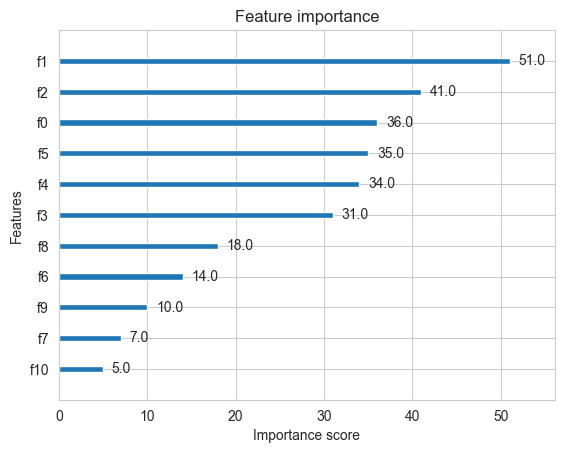

In [96]:
from xgboost import plot_importance

xgb_model = pipeline_xgb.named_steps['classifier']

plot_importance(xgb_model)


ValueError: input_features is not equal to feature_names_in_